In [1]:
import os

In [2]:
os.chdir('../')
%pwd

'/home/paladin/Downloads/Facial_Impression_Recognition_Calassification'

In [3]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class PredictionConfig:
    path_of_model: Path
    path_of_model_json: Path
    pre_trained_face_detector: Path   

In [4]:
from cnnClassifier.constants import *
from cnnClassifier.utils import read_yaml, create_directories

class configurationManeger:
    def __init__(self, 
                 config_filepath = CONFIG_FILE_PATH,
                 secret_filepath = SECRET_FILE_PATH,                 
                 params_filepath = PARAMS_FILE_PATH):
        
        self.config = read_yaml(config_filepath) 
        self.secret = read_yaml(secret_filepath)        
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])  

    def get_prediction_config(self) -> PredictionConfig:
        prediction_config = PredictionConfig(
            path_of_model= self.config.training.trained_model_path,    
            path_of_model_json = self.config.training.trained_model_json_path,       
            pre_trained_face_detector = 'haarcascade_frontalface_default.xml'           
            )
        
        return prediction_config

2023-08-04 13:17:33.888017: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-04 13:17:33.948078: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-04 13:17:33.948825: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 13:17:35.083458: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [21]:
import sys
from cnnClassifier.exception import CustomException
from cnnClassifier.utils import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [22]:
class Prediction:
    def __init__(self, filename: Path, config: PredictionConfig):
        self.config = config
        self.filename = filename
  

    def predict(self):
        emotion_dict = {0: "Neutral", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Sad", 5: "Surprised", 6: "Neutral"}

        model = load_model(h5_path=self.config.path_of_model, json_path= self.config.path_of_model_json)              
        
        facecasc = cv2.CascadeClassifier(self.config.pre_trained_face_detector)
        image = cv2.imread(self.filename)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #faces = facecasc.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=10)
        faces = facecasc.detectMultiScale(image, scaleFactor=1.2, minNeighbors=6)
        print("No of faces : ",len(faces))
        i =1
        for (x, y, w, h) in faces:
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 1)
            # If the input of trained model has one chanels
            roi_gray = gray[y:y + h, x:x + w] 
            # If the input of trained model has three chanels         
            #roi_color = image[y:y+h, x:x+w]               
            # Croping 
            cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)            
            cropped_img = ((cropped_img/255.) - 0.5)*2           
            
            prediction = model.predict(cropped_img)
            maxindex = int(np.argmax(prediction))                              
            print("person ",i," : ",emotion_dict[maxindex])           
            cv2.putText(image, emotion_dict[maxindex], (x+10, y-20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            
            cv2.imshow("Face Detector", image)
            k=cv2.waitKey(2000)
        cv2.destroyAllWindows()
        
        file_name = os.path.basename(self.filename )
        dir_name = os.path.dirname(self.filename) 
        cv2.imwrite(os.path.join(dir_name, 'pred_'+file_name), image)

        image = cv2.imread(os.path.join(dir_name, 'pred_'+file_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        

        return plt.show()

No of faces :  3
1/1 [==============================] - 0s 278ms/step
person  1  :  Neutral
1/1 [==============================] - 0s 31ms/step
person  1  :  Happy
1/1 [==============================] - 0s 31ms/step
person  1  :  Neutral


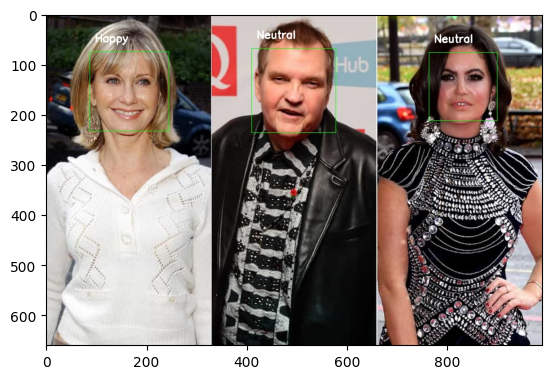

In [23]:
try:
    config = configurationManeger()
    pred_config = config.get_prediction_config()
    prediction = Prediction('images/img2.jpg', pred_config)
    prediction.predict()
    
except Exception as e:
    raise CustomException(e, sys)